In [32]:
from pytorch_lightning import Trainer
from src.helper import Data

In [33]:
import torch.optim as optim
import torch

import pytorch_lightning as pl

from src.mapping_helper import StandardMap


class Model(pl.LightningModule):
    def __init__(self, **params):
        super(Model, self).__init__()
        self.save_hyperparameters()

        self.num_rnn_layers: int = params.get("num_rnn_layers")
        self.num_lin_layers: int = params.get("num_lin_layers")
        self.sequence_type: str = params.get("sequence_type")
        dropout: float = params.get("dropout")
        self.lr: float = params.get("lr")
        self.optimizer: str = params.get("optimizer")

        # ----------------------
        # NOTE: This logic is kept so that variable layer sizes can be reimplemented in the future
        rnn_layer_size: int = params.get("hidden_size")
        lin_layer_size: int = params.get("linear_size")

        self.hidden_sizes: list[int] = [rnn_layer_size] * self.num_rnn_layers
        self.linear_sizes: list[int] = [lin_layer_size] * (self.num_lin_layers - 1)
        # ----------------------

        # Create the RNN layers
        self.rnns = torch.nn.ModuleList([])
        self.rnns.append(torch.nn.RNNCell(2, self.hidden_sizes[0]))
        for layer in range(self.num_rnn_layers - 1):
            self.rnns.append(
                torch.nn.RNNCell(self.hidden_sizes[layer], self.hidden_sizes[layer + 1])
            )

        # Create the linear layers
        self.lins = torch.nn.ModuleList([])
        if self.num_lin_layers == 1:
            self.lins.append(torch.nn.Linear(self.hidden_sizes[-1], 2))
        elif self.num_lin_layers > 1:
            self.lins.append(
                torch.nn.Linear(self.hidden_sizes[-1], self.linear_sizes[0])
            )
            for layer in range(self.num_lin_layers - 2):
                self.lins.append(
                    torch.nn.Linear(
                        self.linear_sizes[layer], self.linear_sizes[layer + 1]
                    )
                )
            self.lins.append(torch.nn.Linear(self.linear_sizes[-1], 2))
        self.dropout = torch.nn.Dropout(p=dropout)

        # takes care of dtype
        self.to(torch.double)

    def _init_hidden(self, shape0: int, hidden_shapes: int) -> list[torch.Tensor]:
        return [
            torch.zeros(shape0, hidden_shape, dtype=torch.double)
            for hidden_shape in hidden_shapes
        ]

    def forward(self, input_t: torch.Tensor) -> torch.Tensor:
        h_ts = self._init_hidden(input_t.shape[0], self.hidden_sizes)

        outputs = []
        for input in input_t.split(1, dim=2):
            input = input.squeeze(2)
            h_ts[0] = self.rnns[0](input, h_ts[0])
            for i in range(1, self.num_rnn_layers):
                h_ts[i] = self.rnns[i](h_ts[i - 1], h_ts[i])
            outputs.append(h_ts[-1])

        outputs = torch.stack(outputs, dim=1)
        for i in range(self.num_lin_layers):
            outputs = self.lins[i](outputs)

        outputs = outputs.transpose(1, 2)

        return outputs

    def configure_optimizers(self) -> optim.Optimizer:
        if self.optimizer == "adam":
            return optim.Adam(self.parameters(), lr=self.lr, amsgrad=True)
        elif self.optimizer == "rmsprop":
            return optim.RMSprop(self.parameters(), lr=self.lr)
        elif self.optimizer == "sgd":
            return optim.SGD(self.parameters(), lr=self.lr, momentum=0.9, nesterov=True)

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        inputs: torch.Tensor
        targets: torch.Tensor
        inputs, targets = batch

        predicted = self(inputs)

        if self.sequence_type == "many-to-one":
            predicted = predicted[:, -1:]

        loss = torch.nn.functional.mse_loss(predicted, targets)

        return loss

In [34]:
params = {
  "init_points": 100,
  "steps": 45,
  "K": 0.5,
  "sampling": "random",
  "hidden_size": 200,
  "linear_size": 100,
  "num_rnn_layers": 2,
  "num_lin_layers": 1,
  "non_linearity": "selu",
  "dropout": 0.0,
  "batch_size": 250,
  "seq_length": 25,
  "loss": "mse",
  "optimizer": "adam",
  "lr": 0.002,
  "precision": "32-true",
  "shuffle_trajectories": True,
  "shuffle_within_batches": False,
  "shuffle_sequences": False,
  "sequence_type": "many-to-one",
}

In [35]:
map_object = StandardMap(seed=42, params=params)

datamodule = Data(
    map_object=map_object,
    train_size=1.0,
    params=params,
    plot_data=False,
    plot_data_split=False,
)

model = Model(**params)
trainer = Trainer(max_epochs=2)
trainer.fit(model, datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/uros/anaconda3/envs/rnn_generator/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")

  | Name    | Type       | Params
---------------------------------------
0 | rnns    | ModuleList | 121 K 
1 | lins    | ModuleList | 402   
2 | dropout | Dropout    | 0     
---------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.486     Total estimated model params size (MB)
/Users/uros/anaconda3/envs/rnn_generator/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloa

Training: 0it [00:00, ?it/s]

/var/folders/ks/31_cqzcn0zn7xqmjvtd52vcm0000gn/T/ipykernel_1659/4237927043.py:101: UserWarning: Using a target size (torch.Size([250, 2, 1])) that is different to the input size (torch.Size([250, 1, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(predicted, targets)
`Trainer.fit` stopped: `max_epochs=2` reached.


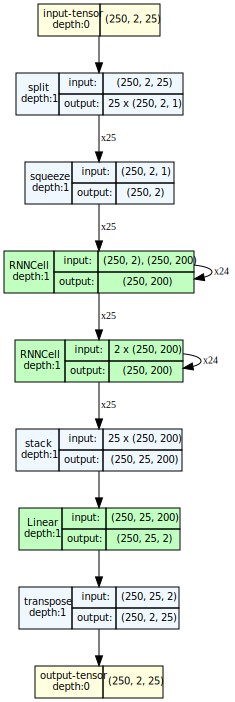

In [36]:
from torchview import draw_graph

model_graph = draw_graph(
    model, input_size=(params.get("batch_size"), 2, params.get("seq_length")), device="cpu", roll=True, save_graph=True, filename="autoregressor_architecture", graph_dir="TB", depth=3, dtypes=[torch.double], hide_module_functions=True, hide_inner_tensors=True,
)
model_graph.visual_graph